In [3]:
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from utils import sqlalchemy_engine

logger = logging.getLogger(__name__)

In [4]:
engine = sqlalchemy_engine()

In [5]:
# create a demongraphic dataframe
demo_query = """
SELECT 
    school_code,
	student_group_id,
	grade,
	max(total_students_enrolled) as total_students_enrolled
FROM scores
WHERE type_id IN (7, 9)
AND total_students_enrolled is not null
GROUP BY school_code, student_group_id, grade"""

demo_df = pd.read_sql_query(demo_query, engine)

# pivot table
demo_pt = demo_df.pivot_table(index=['school_code', 'grade'], columns='student_group_id', values='total_students_enrolled', aggfunc="max")
demo_pt.reset_index(inplace=True)

# convert to ratios
for col in demo_pt.columns[3:]:
    demo_pt[col] = demo_pt[col].div(demo_pt[1]).where(demo_pt[col].notna())
    if demo_pt[demo_pt[1] < demo_pt[col]].size > 0:
        print(f"Warning: {demo_pt[demo_pt[1] < demo_pt[col]].size} rows where col 1 < col {col}")    

In [6]:
score_query = """SELECT 
 	school_code,
	 test_id,
	 grade,
	 (pct_std_exceeded::FLOAT / 100::FLOAT) as pct_std_exceeded,
	 (pct_std_met::FLOAT / 100::FLOAT) as pct_std_met,
	 (pct_std_met_and_above::FLOAT / 100::FLOAT) as pct_std_met_and_above
FROM scores
WHERE type_id IN (7, 9)
AND total_students_enrolled is not null
AND student_group_id = 1"""

score_df = pd.read_sql_query(score_query, engine)
score_df['test_id'] = score_df['test_id'].replace({1: 'MATH', 2: 'ENG'})

score_pt=score_df.pivot(index=['school_code', 'grade'], columns=['test_id'], values=['pct_std_exceeded', 'pct_std_met', 'pct_std_met_and_above'])
score_pt.reset_index(inplace=True)
score_pt.columns = score_pt.columns.map('_'.join).map(str.lower)
score_pt = score_pt.rename(columns={'school_code_': 'school_code', 'grade_': 'grade'})

In [7]:
merged_df = pd.merge(score_pt, demo_pt, on=['school_code', 'grade'], how='left')

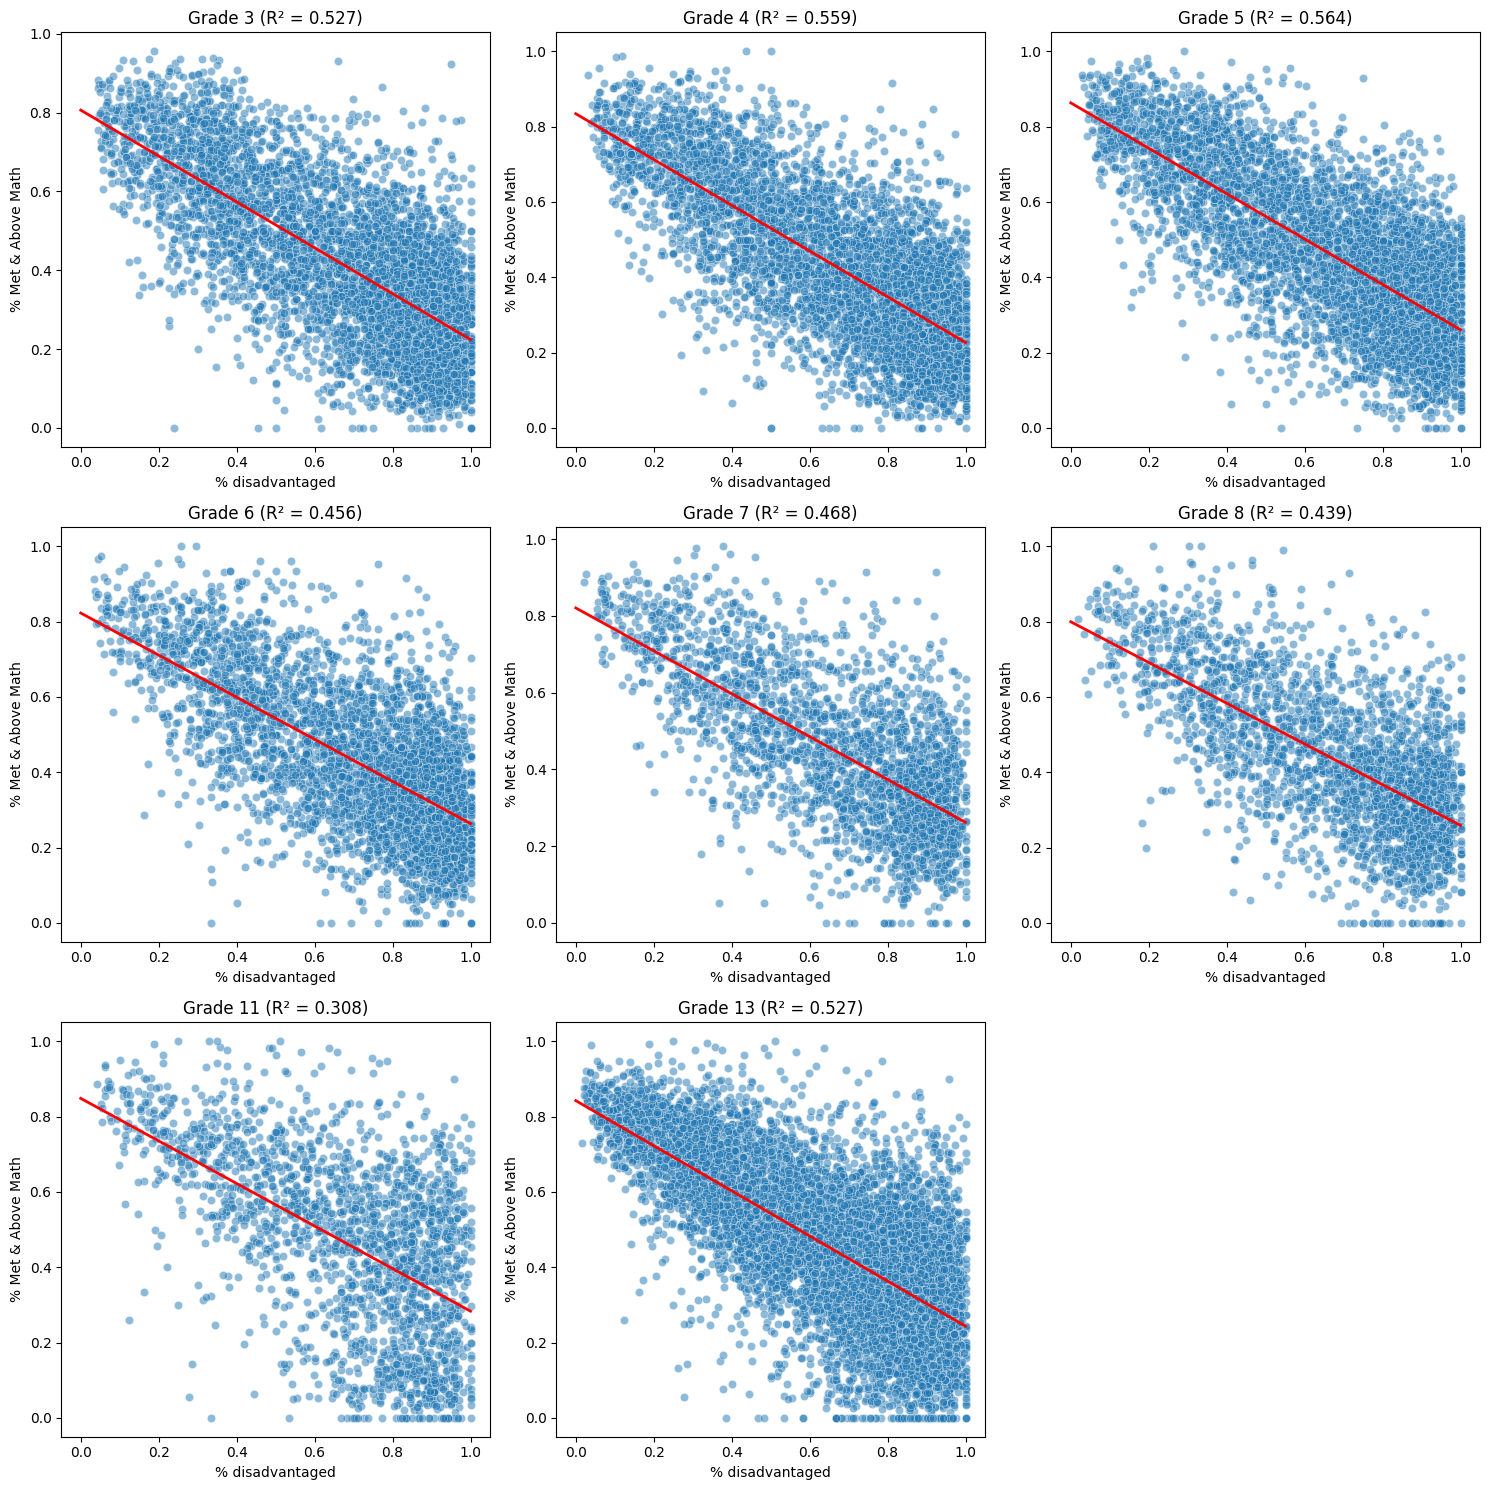

In [8]:
compvar = 31
xlabel = 'disadvantaged'

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

grades = merged_df['grade'].unique()
for idx, grade in enumerate(sorted(grades)):
    # Filter data for current grade
    grade_data = merged_df[merged_df['grade'] == grade]
    
    # Create scatter plot
    sns.scatterplot(data=grade_data, 
                    x=compvar, 
                    y='pct_std_met_and_above_math',
                    alpha=0.5,
                    ax=axes[idx])
    
    # Add regression line
    X = grade_data[compvar].values.reshape(-1, 1)
    y = grade_data['pct_std_met_and_above_math'].values
    mask = ~(np.isnan(X.flatten()) | np.isnan(y))
    X = X[mask]
    y = y[mask]
    
    model = LinearRegression()
    model.fit(X, y)
    
    x_range = np.linspace(0, 1, 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    r2 = r2_score(y, model.predict(X))
    
    axes[idx].plot(x_range, y_pred, 'r-', linewidth=2)
    axes[idx].set_title(f'Grade {grade} (R² = {r2:.3f})')
    axes[idx].set_xlabel(f'% {xlabel}')
    axes[idx].set_ylabel('% Met & Above Math')

# Remove empty subplots if any
for idx in range(len(grades), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [9]:
compvars = [31]

grades = merged_df['grade'].unique()
for idx, grade in enumerate(sorted(grades)):
    # Drop rows with missing values in the specified columns
    grade_data = merged_df[merged_df['grade'] == grade]
    grade_data_clean = grade_data.dropna(subset=compvars + ['pct_std_met_and_above_math'])

    # Extract the cleaned X and y
    X = grade_data_clean[compvars].values
    y = grade_data_clean['pct_std_met_and_above_math'].values.reshape(-1, 1)

    model = LinearRegression()
    model.fit(X, y)
    r2 = r2_score(y, model.predict(X))
    print(f'grade[{grade}]: n={grade_data_clean.size}/{grade_data.size} r={r2:.3f} {model.coef_} {model.intercept_}')

grade[3]: n=369732/388410 r=0.527 [[-0.58195966]] [0.80598856]
grade[4]: n=369930/388674 r=0.559 [[-0.60718691]] [0.83391363]
grade[5]: n=370722/389598 r=0.564 [[-0.60251946]] [0.86279842]
grade[6]: n=266772/286638 r=0.456 [[-0.55883336]] [0.82248417]
grade[7]: n=170676/192126 r=0.468 [[-0.55883205]] [0.82075267]
grade[8]: n=171402/195228 r=0.439 [[-0.54044784]] [0.79930633]
grade[11]: n=135498/156156 r=0.308 [[-0.56484161]] [0.84815619]
grade[13]: n=604626/637296 r=0.527 [[-0.59870439]] [0.84221317]
